<h1><center><font size="25">Functional testing skforecast</font></center></h1>

<center><b>Joaquín Amat Rodrigo</b></center>

<center><i>March, 2021</i></center>

This notebook performs functional testing for the library skforecast.

For unit testing see folder *tests*.

In [1]:
#pip install skforecast
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## ForecasterAutoreg

### No exogenous predictor

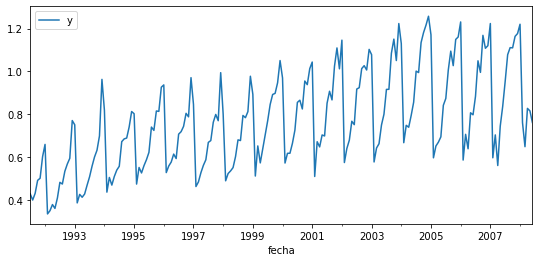

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [3]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 15
                )

forecaster.fit(y=datos_train)
forecaster

=======================ForecasterAutoreg=======================
Regressor: LinearRegression()
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Exogenous variable: False
Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

Test error (mse): 0.01105193704350369


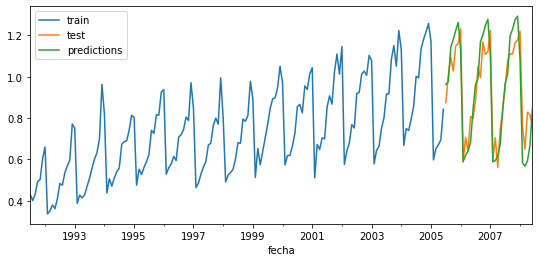

In [4]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

**Expected result:**

Test error (mse): 0.011051937043503738

In [5]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-08-06 16:43:36,970 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:10<00:00,  3.48s/it] 
2021-08-06 16:43:47,419 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.026520
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.026967
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.028092
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.028693
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.029500
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.033252
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.033828
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.034154
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.036539
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.036623


**Expected result (non exact reproducibility):**

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]	{'max_depth': 10, 'n_estimators': 50}	0.026520  

In [6]:
# Predictors importance
# ==============================================================================
print(forecaster.get_feature_importances())

[0.58857871 0.10819445 0.06032462 0.02772937 0.02760762 0.01349508
 0.03496535 0.01883128 0.02761474 0.09265878]


**Expected result (non exact reproducibility)**

[0.58857871 0.10819445 0.06032462 0.02772937 0.02760762 0.01349508
 0.03496535 0.01883128 0.02761474 0.09265878]

In [7]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-08-06 16:44:02,424 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it] 
2021-08-06 16:44:07,628 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3 20] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.050024
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.054322
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.056827
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.056929
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.057539
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.058406
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.058613
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.060764
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.061873
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.062285


**Expected result (non exact reproducibility)**

[1, 2, 3, 20]	{'max_depth': 10, 'n_estimators': 50}	0.057822

In [8]:
# Autorregresive lineal model statsmodels
# ==============================================================================
from statsmodels.tsa.ar_model import AutoReg
lags = 15

modelo_ar = AutoReg(datos_train, lags=lags)
res = modelo_ar.fit()
predictions_statsmodels = res.predict(start=datos_test.index[0], end=datos_test.index[-1])

# Autorregresive lineal model Forecaster
# ==============================================================================
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)
forecaster.fit(y=datos_train)
predictions_forecaster = forecaster.predict(steps=36)

# Predictions from both models must be the equal
# ==============================================================================
print(np.allclose(predictions_statsmodels.values, predictions_forecaster))

# Coeficients from both models must be the equal
# ==============================================================================
print(np.allclose(res.params.values[1:], forecaster.get_coef()))

True
True


/home/ximo/anaconda3/envs/cienciadedatos/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


**Expected result:**

True

True

Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.02150972]


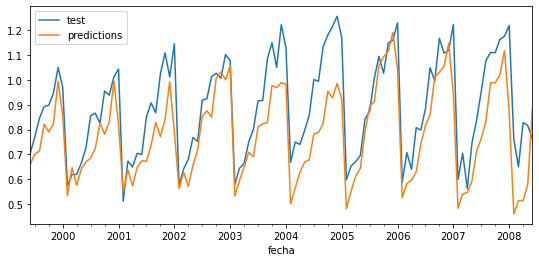

In [9]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)
print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

**Expected result:**

Number of observations used for training: 95

Number of folds: 4

Last fold only includes 1 observations.

[0.02150972]

In [10]:
print(len(predictions_backtest), predictions_backtest)

109 fecha
1999-06-01    0.659751
1999-07-01    0.700833
1999-08-01    0.713227
1999-09-01    0.821183
1999-10-01    0.790163
                ...   
2008-02-01    0.459349
2008-03-01    0.513128
2008-04-01    0.513193
2008-05-01    0.578220
2008-06-01    0.888897
Freq: MS, Length: 109, dtype: float64


**Expected result:**
    
109 fecha
1999-06-01    0.659751
1999-07-01    0.700833
1999-08-01    0.713227
1999-09-01    0.821183
1999-10-01    0.790163
                ...   
2008-02-01    0.459349
2008-03-01    0.513128
2008-04-01    0.513193
2008-05-01    0.578220
2008-06-01    0.888897
Freq: MS, Length: 109, dtype: float64

In [11]:
# Check backtesting predictions
forecaster.fit(y=datos_train)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3])
(predictions_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

True

**Expected result:**
    
True

In [12]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

Test error (mse): 0.01105193704350369


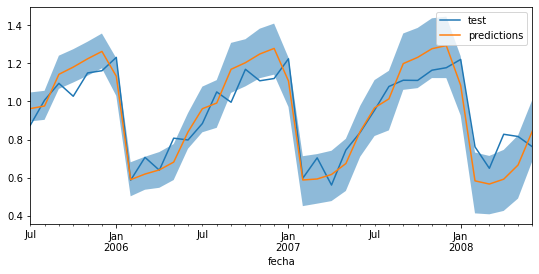

In [13]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor=LinearRegression(),
                    lags=15
                )

forecaster.fit(y=datos_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [5, 95],
                    n_boot   = 1000
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result:**
    
Test error (mse): 0.011051937043503738

Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.02150972]


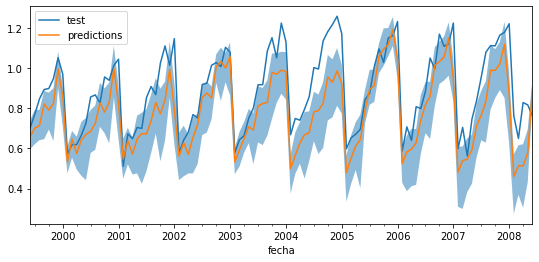

In [14]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metric, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [1, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metric)

# Add datetime index
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result:**
    
Number of observations used for training: 95
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.02150972]

### 1 exogenous predictor
<br>

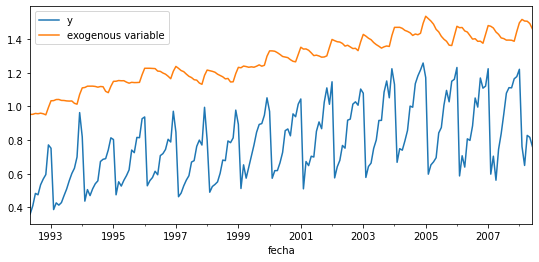

In [15]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
datos_exog = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog = datos_exog[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog.plot(ax=ax, label='exogenous variable')
ax.legend();


# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 0.020306077140235537


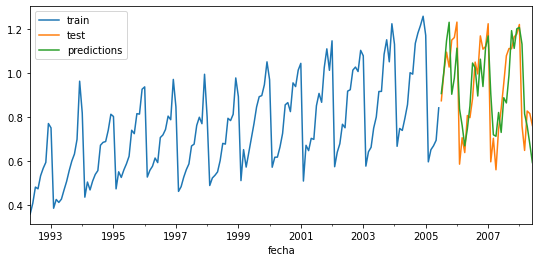

In [16]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 0.020306077140235405

In [17]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-08-06 16:45:31,043 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it] 
2021-08-06 16:45:40,209 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.028383
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.028550
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.028952
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.030860
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.035755
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.037170
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.037354
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.039665
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.041344
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.044439


**Expected result (non exact reproducibility)**

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]	{'max_depth': 10, 'n_estimators': 50}	0.028383

In [18]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-08-06 16:45:40,297 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it] 
2021-08-06 16:45:45,185 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3 20] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.054245
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.059871
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.062230
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.062298
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.062390
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.065474
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.065545
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.066951
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.071877
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.073482


**Expected result (non exact reproducibility)**

[1, 2, 3, 20]	{'max_depth': 10, 'n_estimators': 50}	0.054245

Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.01325921]


True

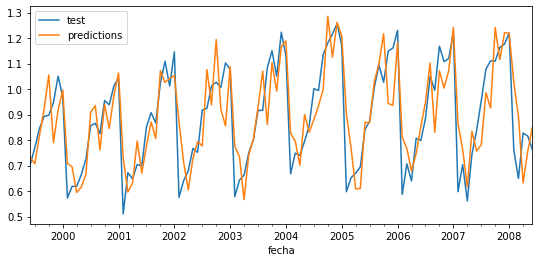

In [19]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
lags  = 8
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

# Check backtesting predictions
forecaster.fit(y=datos_train, exog=datos_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=datos_exog_test[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps], exog=datos_exog_test[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2], exog=datos_exog_test[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3], exog=datos_exog_test[steps*3:steps*4])
(predictions_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

**Expected result**


Number of observations used for training: 85

Number of folds: 4

Last fold only includes 1 observations.

[0.01325921]

True


In [20]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 0.020306077140235537


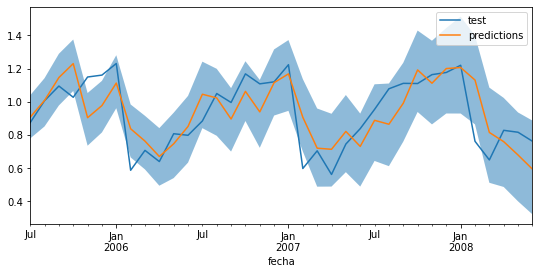

In [21]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result**

Test error (mse): 0.020306077140235405

Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.01325921]


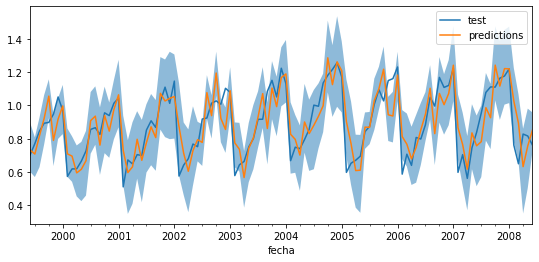

In [22]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metric, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metric)

# Add datetime index
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected values**

Number of observations used for training: 85
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.01325921]

### n exogenous predictors
<br>

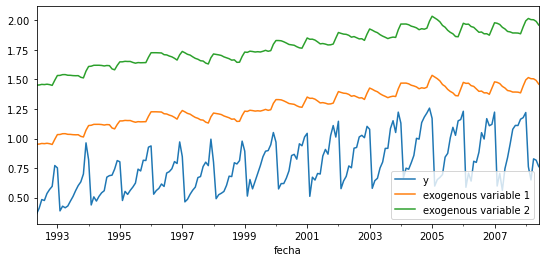

In [23]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_2 = datos.rolling(window=10, closed='right').mean() + 1
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog_1.plot(ax=ax, label='exogenous variable 1')
datos_exog_2.plot(ax=ax, label='exogenous variable 2')
ax.legend();

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

Test error (mse): 0.020306077140235215


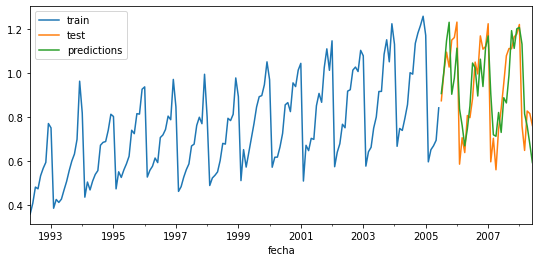

In [24]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 0.02030607714023512

In [25]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-08-06 16:45:56,510 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:09<00:00,  3.07s/it] 
2021-08-06 16:46:05,712 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 5, 'n_estimators': 50}



,lags,params,metric
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.025775
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.027541
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.028391
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.029196
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.036057
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.037904
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.039041
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.040024
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.042173
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.042883


**Expected result (non exact reproducibility)**

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]	{'max_depth': 5, 'n_estimators': 50}	0.025775

In [26]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-08-06 16:46:09,110 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it] 
2021-08-06 16:46:14,016 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3 20] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.053074
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.058703
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.059072
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.059077
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.062055
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.062533
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.062782
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.066737
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.066839
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.067315


**Expected result (non exact reproducibility)**

[1, 2, 3, 20]	{'max_depth': 10, 'n_estimators': 50}	0.053074

Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.01325921]


True

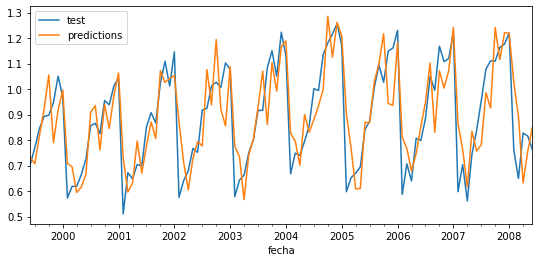

In [27]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test,]
datos_exog_test  = datos_exog[-n_test:,]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)
print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

# Check backtesting predictions
forecaster.fit(y=datos_train, exog=datos_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=datos_exog_test[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps], exog=datos_exog_test[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2], exog=datos_exog_test[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3], exog=datos_exog_test[steps*3:steps*4])
(predictions_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

**Expected result**

Number of observations used for training: 85

Number of folds: 4

Last fold only includes 1 observations.

[0.01325921]

In [28]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

Test error (mse): 0.020306077140235215


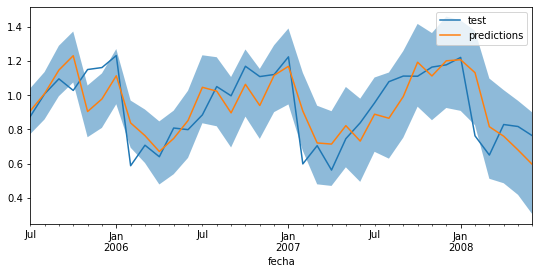

In [29]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected value**

Test error (mse): 0.02030607714023512

Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.01325921]


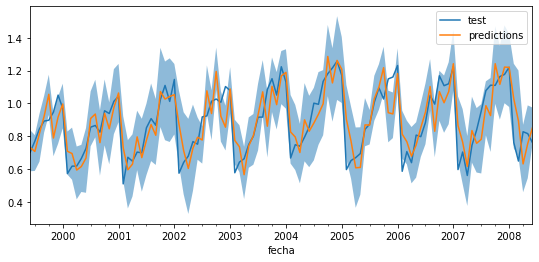

In [30]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metric, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metric)

# Add datetime index
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected value**

Number of observations used for training: 85
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.01325921]

## ForecasterCustom

### No exogenous predictor

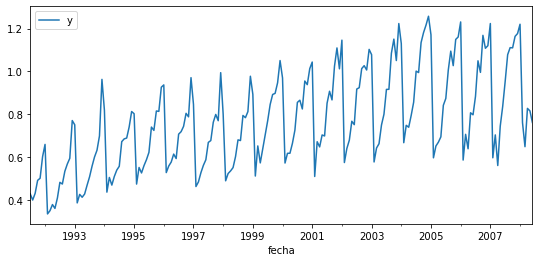

In [31]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [32]:
# Custom function to create poredictors
# ==============================================================================
def create_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 10):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(20).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train  

In [34]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train)
forecaster

=======================ForecasterAutoregCustom=======================
Regressor: LinearRegression()
Predictors created with: create_predictors
Window size: 20
Exogenous variable: False
Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

Test error (mse): 0.024334075665271588


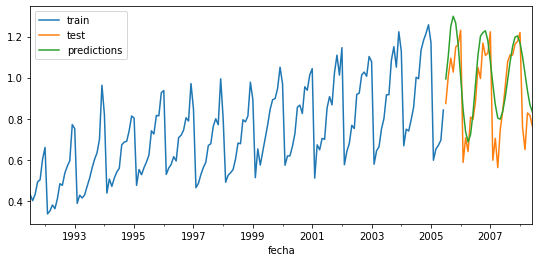

In [35]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

**Expected result**

Test error (mse): 0.024334075665271356

In [37]:
# Grid search hiperparameters
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}


results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        steps       = 36,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-08-06 16:47:58,273 root       INFO  Number of models to fit: 4
loop lags_grid: 100%|██████████| 1/1 [00:05<00:00,  5.98s/it] 
2021-08-06 16:48:04,260 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.021727
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.022134
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.028108
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.032680


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 10, 'n_estimators': 50}	0.021727

In [38]:
# Grid search hiperparameters
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}


results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        steps       = 36,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-08-06 16:48:10,133 root       INFO  Number of models to fit: 4
loop lags_grid: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it] 
2021-08-06 16:48:14,567 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 5, 'n_estimators': 100}



,lags,params,metric
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.058251
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.059011
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.061352
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.063328


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 5, 'n_estimators': 100}	0.058251

In [38]:
# Predictors importance
# ==============================================================================
print(forecaster.get_feature_importances())

[0.57288524 0.10786513 0.04122763 0.01995047 0.02905527 0.00950056
 0.04106364 0.01010964 0.0155692  0.11264308 0.04013015]


**Expected result (non exact reproducibility)**

[0.57297604 0.10797729 0.04122921 0.01996422 0.02964171 0.00950612
 0.04090579 0.0101996  0.01486522 0.11273685 0.03999795]

Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.06468538]


True

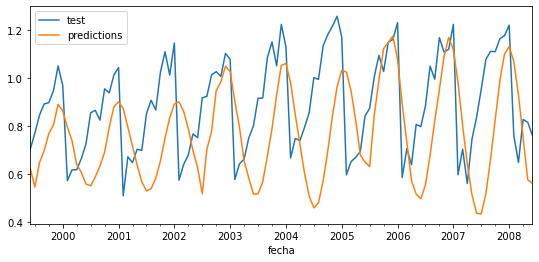

In [39]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

# Check backtesting predictions
forecaster.fit(y=datos_train)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3])
np.allclose(predictions_backtest, np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

**Expected result**

Number of observations used for training: 95

Number of folds: 4

Last fold only includes 1 observations.

[0.06468538]

In [40]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

Test error (mse): 0.024334075665271588


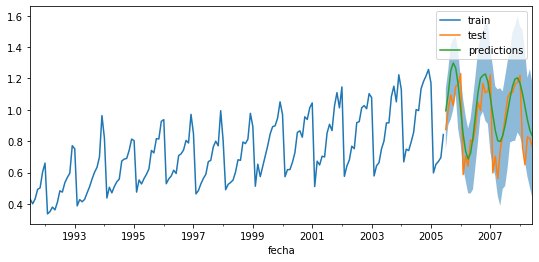

In [41]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [5, 95],
                    n_boot   = 100
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result:**
    
Test error (mse): 0.024334075665271356

Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.06468538]


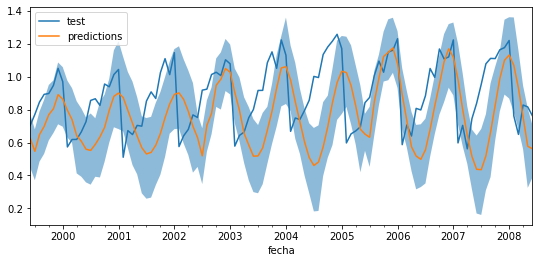

In [42]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metric, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metric)

# Add datetime index
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result:**
    
Number of observations used for training: 95
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.06468538]

### 1 exogenous predictor
<br>

In [43]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
np.random.seed(123)
datos_exog = datos.rolling(window=10, closed='right').mean()
datos_exog = datos_exog[10:]
datos = datos[10:]

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

In [44]:
# Custom function to create poredictors
# ==============================================================================
def create_predictors(y):
    '''
    Create first 8 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 8):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(20).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train 

Test error (mse): 0.019532908207755516


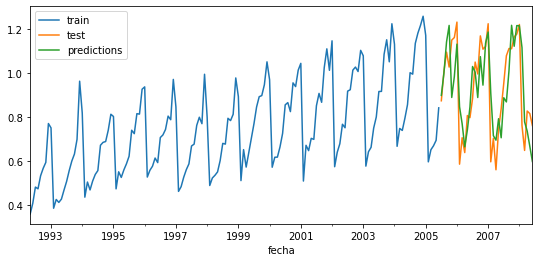

In [46]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 0.01953290820775534

In [47]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-08-06 16:51:28,399 root       INFO  Number of models to fit: 4
loop lags_grid: 100%|██████████| 1/1 [00:13<00:00, 13.49s/it] 
2021-08-06 16:51:41,895 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.021677
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.022551
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.022610
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.023240


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 10, 'n_estimators': 50}	0.021677


In [48]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-08-06 16:51:42,464 root       INFO  Number of models to fit: 4
loop lags_grid: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it] 
2021-08-06 16:51:46,109 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 5, 'n_estimators': 100}



,lags,params,metric
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.074586
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.075490
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.077318
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.078905


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 5, 'n_estimators': 100}	0.074586

Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.01351212]


True

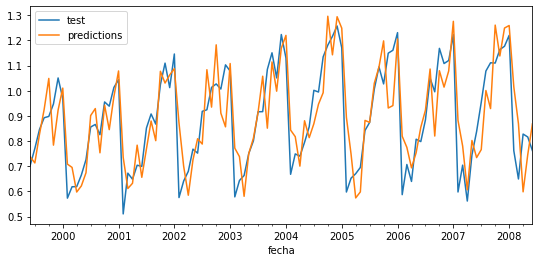

In [50]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoregCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

# Check backtesting predictions
forecaster.fit(y=datos_train, exog=datos_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=datos_exog_test[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps], exog=datos_exog_test[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2], exog=datos_exog_test[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3], exog=datos_exog_test[steps*3:steps*4])
np.allclose(predictions_backtest, np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

**Expected result**

Number of observations used for training: 85

Number of folds: 4

Last fold only includes 1 observations.

[0.01351212]

True

In [51]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 0.019532908207755516


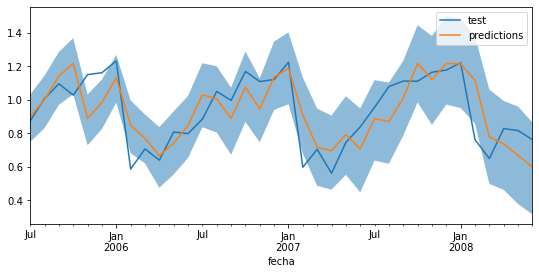

In [52]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result**

Test error (mse): 0.01953290820775534

Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.01351212]


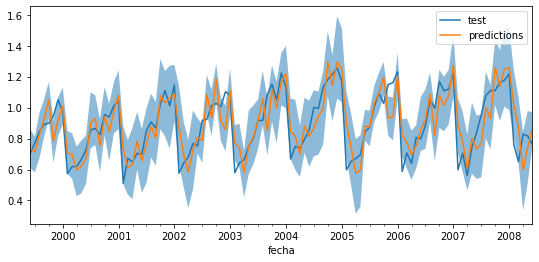

In [53]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metric, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metric)

# Add datetime index
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected values**

Number of observations used for training: 85
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.01351212]

### n exogenous predictors
<br>

In [54]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_2 = datos.rolling(window=10, closed='right').mean() + 1
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos[10:]

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

In [53]:
# Custom function to create poredictors
# ==============================================================================
def create_predictors(y):
    '''
    Create first 8 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 8):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(20).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train 

Test error (mse): 0.019533047185299746


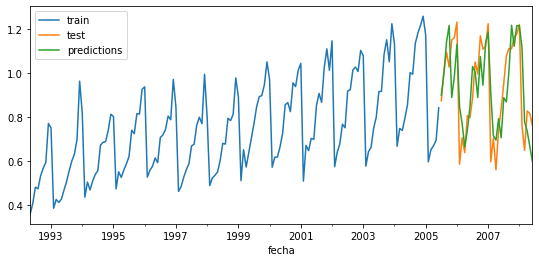

In [55]:
# Create and fit forecaster
# ==============================================================================
regressor = LinearRegression()
forecaster = ForecasterAutoregCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 0.019513797137144007

In [56]:
# Grid search hiperparameters and lags
# ==============================================================================
regressor = RandomForestRegressor(random_state=123)
forecaster = ForecasterAutoregCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-08-06 16:54:03,238 root       INFO  Number of models to fit: 4
loop lags_grid: 100%|██████████| 1/1 [00:14<00:00, 14.47s/it] 
2021-08-06 16:54:17,714 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 5, 'n_estimators': 100}



,lags,params,metric
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.022885
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.023091
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.023435
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.023598


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 5, 'n_estimators': 100}	0.022885

In [57]:
# Grid search hiperparameters and lags
# ==============================================================================
regressor = RandomForestRegressor(random_state=123)
forecaster = ForecasterAutoregCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-08-06 16:54:18,372 root       INFO  Number of models to fit: 4
loop lags_grid: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it] 
2021-08-06 16:54:22,409 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 5, 'n_estimators': 100}



,lags,params,metric
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.072913
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.073533
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.074672
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.078605


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 5, 'n_estimators': 100}	0.072913

[0.01351212]


True

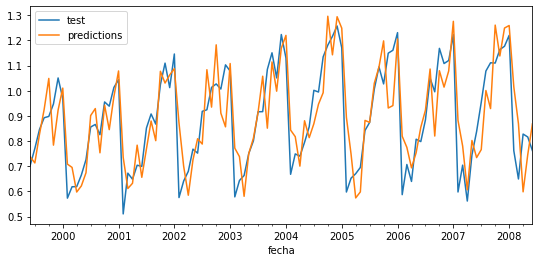

In [58]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test,]
datos_exog_test  = datos_exog[-n_test:,]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoregCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error'
)

print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();


# Check backtesting predictions
forecaster.fit(y=datos_train, exog=datos_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=datos_exog_test[:steps,])
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps], exog=datos_exog_test[steps:steps*2,])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2], exog=datos_exog_test[steps*2:steps*3,])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3], exog=datos_exog_test[steps*3:steps*4,])
np.allclose(predictions_backtest, np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

**Expected result**

Number of observations used for training: 85

Number of folds: 4

Last fold only includes 1 observations.

[0.01351212]

True

## ForecasterAutoregMultiOutput

### No exogenous predictor

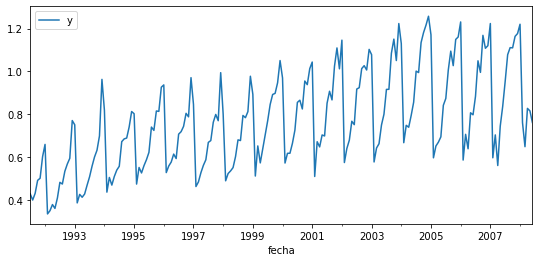

In [59]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [60]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 15
                )

forecaster.fit(y=datos_train)
forecaster

forecaster

============================ForecasterAutoregMultiOutput============================
Regressor: LinearRegression()
Steps: 36
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Exogenous variable: False
Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

Test error (mse): 0.009127719994536921


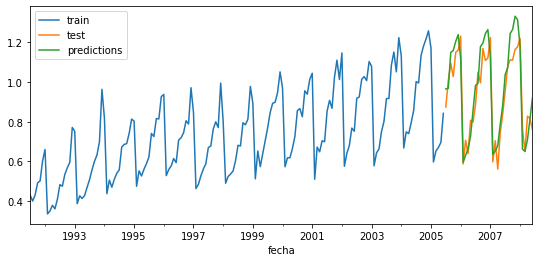

In [61]:
# Predict
# ==============================================================================
predictions = forecaster.predict()
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

**Expected result**

Test error (mse): 0.009127719994536924

In [62]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 3
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = forecaster.steps,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-08-06 16:54:25,081 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:57<00:00, 19.02s/it] 
2021-08-06 16:55:22,137 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 100}



,lags,params,metric
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.013687
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.013860
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.013881
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.014137
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.042516
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.042600
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.043118
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.043220
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.067066
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.067744


**Expected result (non exact reproducibility)**

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]	{'max_depth': 10, 'n_estimators': 100}	0.013687

In [63]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 3
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = forecaster.steps,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-08-06 16:55:25,805 root       INFO  Number of models to fit: 12
loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]2021-08-06 16:55:27,243 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 12 observations are excluded.

loop param_grid:  25%|██▌       | 1/4 [00:01<00:04,  1.65s/it]2021-08-06 16:55:30,215 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 12 observations are excluded.

loop param_grid:  50%|█████     | 2/4 [00:04<00:05,  2.55s/it]2021-08-06 16:55:32,053 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 12 observations are excluded.

loop param_grid:  75%|███████▌  | 3/4 [00:06<00:02,  2.13s/it]2021-08-06 16:55:35,092 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 12 observations are excluded.

loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]2021-08-06 16:55:37,019 root       WA

,lags,params,metric
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.018972
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.019110
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.019504
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.019712
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.055578
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.055920
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.056029
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.056035
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.077924
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.078125


**Expected result (non exact reproducibility)**

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]	{'max_depth': 5, 'n_estimators': 100}	0.018972

2021-08-06 16:55:58,780 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 1 observations are excluded.


Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 3
    Number of steps per fold: 36
[0.0328557]


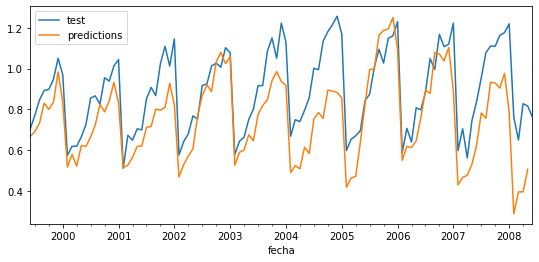

In [64]:
# Backtest 
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 15
             )

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest,
                                 index=datos_test[:len(predictions_backtest)].index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

**Expected result**

Number of observations used for training: 95
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.0328557]

### 1 exogenous predictor
<br>

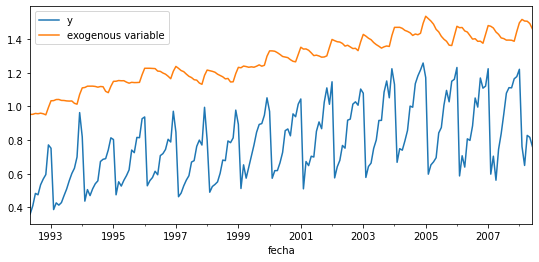

In [65]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
datos_exog = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog = datos_exog[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog.plot(ax=ax, label='exogenous variable')
ax.legend();


# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 0.007698900889415667


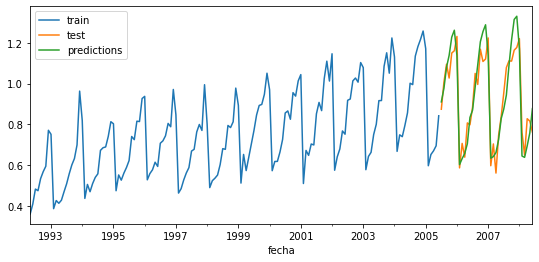

In [66]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 8
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 0.007698900889415667

In [67]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 8
                )


# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = forecaster.steps,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-08-06 16:55:59,440 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [01:01<00:00, 20.46s/it] 
2021-08-06 16:57:00,830 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 5, 'n_estimators': 100}



,lags,params,metric
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.036430
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.036590
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.037795
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.038231
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.038553
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.039121
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.039791
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.040237
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.041292
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.041570


**Expected result (non exact reproducibility)**

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]	{'max_depth': 5, 'n_estimators': 100}	0.036430

In [68]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 8
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = forecaster.steps,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-08-06 16:57:04,491 root       INFO  Number of models to fit: 12
loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]2021-08-06 16:57:05,913 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 7 observations are excluded.

loop param_grid:  25%|██▌       | 1/4 [00:01<00:04,  1.65s/it]2021-08-06 16:57:08,993 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 7 observations are excluded.

loop param_grid:  50%|█████     | 2/4 [00:04<00:05,  2.62s/it]2021-08-06 16:57:10,882 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 7 observations are excluded.

loop param_grid:  75%|███████▌  | 3/4 [00:06<00:02,  2.19s/it]2021-08-06 16:57:13,852 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 7 observations are excluded.

loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]2021-08-06 16:57:15,732 root       WARNIN

,lags,params,metric
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.041764
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.041767
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.042962
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.043105
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.046193
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.046512
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.046530
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.046566
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.046644
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.047293


**Expected result (non exact reproducibility)**

3	{'estimator__max_depth': 10, 'estimator__n_est...	0.055089

2021-08-06 16:57:35,836 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 1 observations are excluded.


Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 3
    Number of steps per fold: 36
[0.02960525]


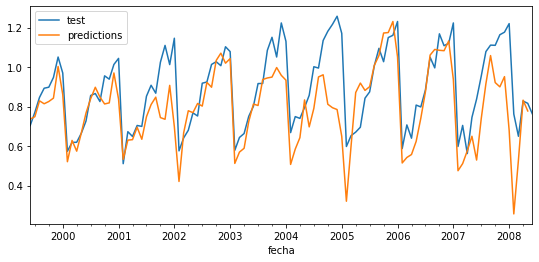

In [69]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]


forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 8
                )

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test[:len(predictions_backtest)].index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

**Expected result**


Number of observations used for training: 85

Number of folds: 4

Number of steps per fold: 36

[0.06737841]


## Session information

In [71]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.3.2
numpy               1.19.2
pandas              1.2.4
session_info        1.0.0
sinfo               0.3.4
skforecast          0.1.9
sklearn             0.24.2
statsmodels         0.12.2
-----
IPython             7.22.0
jupyter_client      6.1.7
jupyter_core        4.6.3
jupyterlab          2.1.3
notebook            6.4.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.11.0-25-generic-x86_64-with-debian-bullseye-sid
-----
Session information updated at 2021-08-06 16:57


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.